# Graded Assignment 4
## SQL and Exploratory Data Analysis

The following learn-by-building exercise will guide you through the process of building out a simple analysis along with some accompanying charts. This module is considerably more difficult than similar exercise blocks in the past, but it sure is a lot more rewarding!

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data_input/chinook.db")

![](assets/chinookschema2.png)

Let's try by first constructing a DataFrame using the `read_sql_query()` method that we've grown familiar to. We want to develop a simple sales visualization report of our top 5 key markets (`Country` column in `customers`) ranked by Sales (`Total` column in `invoices`). 

We also want to identify our top 5 customers by name (`FirstName`, `LastName`) in the report.

Last but not least, we want the report to include a day-of-week analysis on sales performance, and for that we will need the `InvoiceDate` column. 

> **Hint 1**: `pandas` has built-in methods of extracting the name of day in a week. We've seen this in Part 2 of this specialization (**Working with Datetime chapter**). An example usage is:
>
> `data['InvoiceDOW'] = data['InvoiceDate'].dt.day_name()`
>
>  **Hint 2**: In `read_sql_query`, you can use the `parse_dates='InvoiceDate'` argument to have the specified column parsed as date, saving you from a `to_datetime()` conversion

In [3]:
## Your code here
df = pd.read_sql_query(
    '''
    SELECT invoices.InvoiceDate, 
        customers.FirstName ||' '|| customers.LastName as CustomerName, 
        customers.Country,
        invoices.Total 
    FROM customers
    LEFT JOIN invoices
    ON customers.CustomerId = invoices.CustomerId
    ''',
    conn,
    parse_dates='InvoiceDate')

df['InvoiceDOW'] = df['InvoiceDate'].dt.day_name()
df.head()

,InvoiceDate,CustomerName,Country,Total,InvoiceDOW
0,2010-03-11,Luís Gonçalves,Brazil,3.98,Thursday
1,2010-06-13,Luís Gonçalves,Brazil,3.96,Sunday
2,2010-09-15,Luís Gonçalves,Brazil,5.94,Wednesday
3,2011-05-06,Luís Gonçalves,Brazil,0.99,Friday
4,2012-10-27,Luís Gonçalves,Brazil,1.98,Saturday


1. Which of the following customers are among the top 5 customers ranked by their respective total (`Total`)?
    - [ ] Victor Stevens
    - [X] **Hugh O'Reilly**
    - [ ] Puja Srivastava
    - [ ] Astrid Gruber	

In [4]:
## Your code here
df.groupby('CustomerName').sum()[['Total']].sort_values(by='Total',ascending=False).head()

,Total
CustomerName,
Helena Holý,49.62
Richard Cunningham,47.62
Luis Rojas,46.62
Ladislav Kovács,45.62
Hugh O'Reilly,45.62


2. Which of the following countries are among the top 5 grossing ranked by their respective total (`Total`)?
    - [ ] United Kingdom
    - [X] **Germany**
    - [ ] Portugal
    - [ ] India

In [5]:
## Your code here
df.groupby('Country').sum()[['Total']].sort_values(by='Total',ascending=False).head()

,Total
Country,
USA,523.06
Canada,303.96
France,195.10
Brazil,190.10
Germany,156.48


Use the code block below as reference to create a DataFrame containing records where the customers are from one of the top 5 countries. Notice that we have additionally converted our day-of-week column into a `Categorical` column:

```
top5 = ______.groupby('Country').Total.sum().sort_values(ascending=False).head().index.to_list()

top5_data = ______[______['Country'].isin(top5)].copy()

dayorder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
top5_data['InvoiceDOW'] = pd.Categorical(top5_data['InvoiceDOW'],
                                         categories=dayorder,
                                         ordered=True)
top5_data
```

In [6]:
top5 = df.groupby('Country').Total.sum().sort_values(ascending=False).head().index.to_list()

top5_data = df[df['Country'].isin(top5)].copy()

dayorder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
top5_data['InvoiceDOW'] = pd.Categorical(top5_data['InvoiceDOW'],
                                         categories=dayorder,
                                         ordered=True)
top5_data.head()

,InvoiceDate,CustomerName,Country,Total,InvoiceDOW
0,2010-03-11,Luís Gonçalves,Brazil,3.98,Thursday
1,2010-06-13,Luís Gonçalves,Brazil,3.96,Sunday
2,2010-09-15,Luís Gonçalves,Brazil,5.94,Wednesday
3,2011-05-06,Luís Gonçalves,Brazil,0.99,Friday
4,2012-10-27,Luís Gonçalves,Brazil,1.98,Saturday


3. How many sales transactions (or records, or rows) were from the top 5 countries?
    - [ ] 7
    - [X] **245**
    - [ ] 412
    - [ ] 1715

In [7]:
## Your code here
len(top5_data)

245

4. Using the `pd.pivot_table()` method, answer the next two questions: How much sales (`Total`) did we make in total (`sum`) from the France market on a Tuesday? How much sales did we make in total from all the top 5 markets combined on a Friday?
    - [ ] 160.41 / 173.31  
    - [ ] 160.41 / 326.77
    - [X] **1.98 / 173.31**
    - [ ] 1.98 / 326.77

In [10]:
# How much sales (Total) did we make in total (sum) from the France market on a Tuesday?
france_on_tuesday = top5_data[(top5_data['Country'] == 'France') & (top5_data['InvoiceDOW'] == 'Tuesday')]
france_on_tuesday[['Total']]

,Total
270,1.98


In [11]:
pd.pivot_table(
    france_on_tuesday,
    index='Country',
    values = 'Total',
    aggfunc='sum')

,Total
Country,
France,1.98


In [12]:
##How much sales did we make in total from all the top 5 markets combined on a Friday?

#filter ke hari jumat
top5_on_friday = top5_data[top5_data['InvoiceDOW'] == 'Friday']
top5_on_friday['Total'].sum()

173.31

In [13]:
#penambahan param margin=True untuk melihat total sales semua negara
pd.pivot_table(
    top5_on_friday,
    index='Country',
    values = 'Total',
    aggfunc='sum',
    margins=True)

,Total
Country,
Brazil,16.83
Canada,58.41
France,1.98
Germany,8.91
USA,87.18
All,173.31


5. Give the `pivot_table` that you created a name. Remove the margins if they were included in the earlier step. Create a visualization by chaining the `.plot()` method on the pivot table. Set the `kind` parameter to be one of: `line`, `bar`, `scatter` & `box`. Which one is the **LEAST** appropriate plot type(s)?
    - [ ] `line`
    - [ ] `bar`
    - [X] **`scatter`**
    - [ ] `box`

In [14]:
## Your code here
top5_friday_pivot = pd.pivot_table(
    top5_on_friday,
    index='Country',
    values = 'Total',
    aggfunc='sum')
top5_friday_pivot.plot(kind='scatter')

ValueError: scatter requires an x and y column

6. Suppose we want to compare the best-selling music genres in the top 5 countries. Let's try by first filling in the blanks (______) in the query below:
```
genre = pd.read_sql_query(
    '''
    SELECT 
    BillingCountry AS Country, ______.Name AS Genre 
    FROM ______ 
    LEFT JOIN invoice_items ON invoices.______ = invoice_items.______
    LEFT JOIN tracks ON invoice_items.______ = ______.______ 
    LEFT JOIN ______ ON tracks.______ = genres.______
    WHERE BillingCountry IN ('USA', 'Canada', 'France', 'Brazil', 'Germany')
    ''',conn)
```


In [15]:
## Your code here
genre = pd.read_sql_query(
 '''
 SELECT 
 BillingCountry AS Country, genres.Name AS Genre 
 FROM invoices 
 LEFT JOIN invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId
 LEFT JOIN tracks ON invoice_items.TrackId = tracks.TrackId 
 LEFT JOIN genres ON tracks.GenreId = genres.GenreId
 WHERE BillingCountry IN ('USA', 'Canada', 'France', 'Brazil', 'Germany')
 ''',conn)
genre.head()

,Country,Genre
0,Germany,Rock
1,Germany,Rock
2,Canada,Rock
3,Canada,Rock
4,Canada,Rock


Once you've completed the query for `genre` dataframe above, copy and run the code below to create a bar chart which compares the best-selling song genres per country.
```
genre.\
groupby(['Country','Genre']).size().reset_index(name = 'Total Bought').\
sort_values(['Country','Total Bought'], ascending=False).\
groupby('Country').head(5).\
pivot(index = 'Country', columns = 'Genre').plot(kind='bar',stacked=True).\
legend(bbox_to_anchor=(1, 1), loc=2) 
```
What genre is **not** among the top-selling genre in Germany:
   - [ ] Blues
   - [X] **Jazz**
   - [ ] Alternative & Punk
   - [ ] Latin

Germany top-selling:
- Rock
- Metal
- Latin
- Blues
- Alternative & Punk

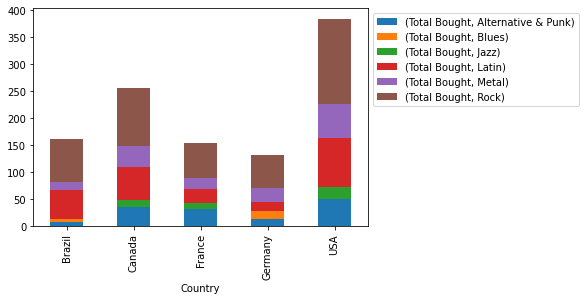

In [16]:
genre.\
groupby(['Country','Genre']).size().reset_index(name = 'Total Bought').\
sort_values(['Country','Total Bought'], ascending=False).\
groupby('Country').head(5).\
pivot(index = 'Country', columns = 'Genre').plot(kind='bar',stacked=True).\
legend(bbox_to_anchor=(1, 1), loc=2) 